starting from 
   RunModel_IntervalTracks_to_KDE_15July_HalfDozen_iter0-testing-10epochs-1em5
create 
   RunModel_IntervalTracks_to_KDE_05August_HalfDozen128_iter0-testing-10epochs-1em4

In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.21.2
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Fri Aug  5 23:29:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   28C    P8    21W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

In [4]:
import torch
print(torch.__version__)
print(torch.cuda)

1.8.2+cu111
<module 'torch.cuda' from '/data/home/sokoloff/.local/lib/python3.7/site-packages/torch/cuda/__init__.py'>


> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.21.2


### Set up local parameters

In [6]:
n_epochs = 500

# Name is the output file name


##  220805  mds
folder = '05August_Tracks_to_KDE_HalfDozen128_first_learning_iter0_500epochs_1em4'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [7]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [8]:
## collectdata_kde_Ellipsoids_29Aug2021 adds zBin and zOffset to X[]
## from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
##from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
## revert to traditional collect_t2kde_data
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
## use July 2022 version of collect_t2kde_data for testing stgructure
## (and later for modifying structure of X[] and Y[])
from model.collectdata_kde_Ellipsoids_jul2022 import collect_t2kde_data_128bins


## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
from model.interval_kde_loss_Ba import Loss_128bins

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_July2022_kde import TrackIntervalsToKDE_HalfDozen128 as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [9]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [10]:
##device = "cuda"
device = select_gpu(2)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 3090


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [12]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
loss = Loss_128bins(epsilon=1e-5,coefficient=2.5)

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
ct, child =  5    Linear(in_features=20, out_features=128, bias=True)


Let's move the model's weight matricies to the GPU:

In [13]:
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]


model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/05August_Tracks_to_KDE_HalfDozen128_first_learning_iter0_500epochs_1em4
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias


In [16]:
"""
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')

##  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
pretrained_dict = torch.load('ML/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6/06November_testing_DirtyDozen_first_learning_iterB_20epochs_1em6_final.pyt')
print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)
"""

'\n##print("updated model_dict = ",model_dict)\n\n## print(" \n","  for pretrained_dict")\n## index = 0\n##for k,v in pretrained_dict.items():\n##    print("index, k =  ",index,"  ",k)\n##    index = index+1\n## mds  \n\n##pretrained_dict = torch.load(\'ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt\')\n##print("model_dict instantiated")\n# 1. filter out unnecessary keys\n##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}\n##print("pretrained_dict iterated")\n# 2. overwrite entries in the existing state dict\n##model_dict.update(pretrained_dict) \n##\n#   when starting from a model with a fully connected last layer rather than a convolutional layer\n# 3. load the new state dict\n#   need to use strict=False as the two models state model attributes do not agree exactly\n#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict\n\

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [17]:
##### Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data_128bins('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/100_POCA_kernel_evts_210829.h5',                                  
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                           device=device,
##  slice is used as index in feature set defined in terms of intervals
##  and there are 800K intervals in a file with 20K events
                           slice = slice(None,500000)
                           )
                            

Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  128
nIntervals =        31
nBins =  4000
binsPerInterval*nIntervals =  3968
intervalKernels.shape =  (620000, 128)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1

len(X) =  20000
len(X_ints) = 620000
len(Xlist) =  1
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 52.44 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 2.049 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t_intervals.shape =  torch.Size([500000, 9, 150])
x_t_intervals.shape[0] =  500000
x_t_intervals.shape[1] =  9
y_t.shape =  torch.Size([20000, 12000])
y_t_intervals.shape =  torch.Size([500000, 384])
y_t_intervals.shape[0] =  500000
y_t_intervals.shape[1] =  384


In [18]:
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data_128bins('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(500000,None)
                           )

Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  128
nIntervals =        31
nBins =  4000
binsPerInterval*nIntervals =  3968
intervalKernels.shape =  (620000, 128)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1

len(X) =  20000
len(X_ints) = 620000
len(Xlist) =  1
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 51.45 s
outer loop X.shape =  (20000, 9, 600)
Constructing 0 event dataset took 0.4022 s
x_t.shape =  torch.Size([0, 9, 600])
x_t.shape[0] =  0
x_t.shape[1] =  9
x_t_intervals.shape =  torch.Size([120000, 9, 150])
x_t_intervals.shape[0] =  120000
x_t_intervals.shape[1] =  9
y_t.shape =  torch.Size([0, 12000])
y_t_intervals.shape =  torch.Size([120000, 384])
y_t_intervals.shape[0] =  120000
y_t_intervals.shape[1] =  384


with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


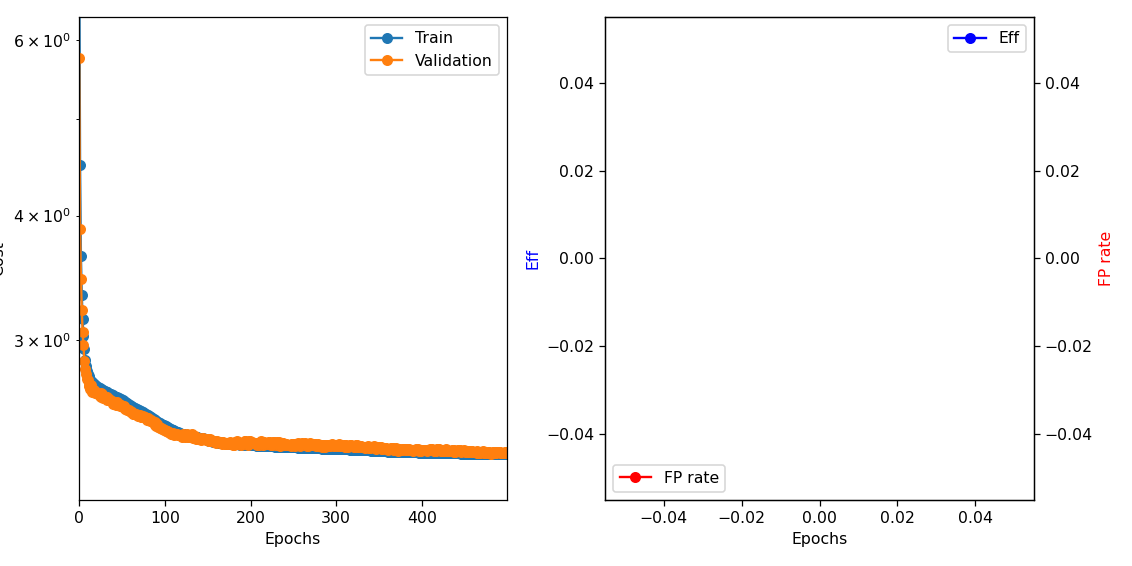

In [19]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [20]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 7813, val = 1875


Number of batches: train = 7813, val = 1875


Epoch 0: train=7.36824, val=5.7508, took 45.366 s


Epoch 1: train=4.49907, val=3.8804, took 44.641 s


Epoch 2: train=3.64211, val=3.45326, took 43.696 s


Epoch 3: train=3.33352, val=3.21392, took 44.956 s


Epoch 4: train=3.1477, val=3.05584, took 45.731 s


Epoch 5: train=3.0267, val=2.96729, took 46.328 s


Epoch 6: train=2.93944, val=2.85968, took 43.758 s


Epoch 7: train=2.86689, val=2.80726, took 41.553 s


Epoch 8: train=2.82678, val=2.77675, took 41.0 s


Epoch 9: train=2.79433, val=2.74346, took 40.959 s


Epoch 10: train=2.7747, val=2.73698, took 40.961 s


Epoch 11: train=2.76086, val=2.69837, took 40.977 s


Epoch 12: train=2.7492, val=2.70855, took 40.497 s


Epoch 13: train=2.73999, val=2.68333, took 41.193 s


Epoch 14: train=2.73201, val=2.70395, took 41.088 s


Epoch 15: train=2.7244, val=2.66402, took 41.407 s


Epoch 16: train=2.71846, val=2.67267, took 40.729 s


Epoch 17: train=2.71348, val=2.67399, took 40.393 s


Epoch 18: train=2.70746, val=2.6565, took 41.265 s


Epoch 19: train=2.70361, val=2.66321, took 42.98 s


Epoch 20: train=2.69979, val=2.66169, took 41.924 s


Epoch 21: train=2.6957, val=2.65539, took 42.08 s


Epoch 22: train=2.69174, val=2.65208, took 41.181 s


Epoch 23: train=2.68828, val=2.64884, took 40.909 s


Epoch 24: train=2.68515, val=2.64029, took 40.96 s


Epoch 25: train=2.68244, val=2.65697, took 40.909 s


Epoch 26: train=2.67874, val=2.63195, took 41.322 s


Epoch 27: train=2.67606, val=2.6483, took 42.596 s


Epoch 28: train=2.67324, val=2.6266, took 41.005 s


Epoch 29: train=2.67041, val=2.63441, took 46.553 s


Epoch 30: train=2.66745, val=2.62385, took 40.631 s


Epoch 31: train=2.66466, val=2.63506, took 40.956 s


Epoch 32: train=2.66177, val=2.61245, took 40.712 s


Epoch 33: train=2.65954, val=2.63074, took 40.803 s


Epoch 34: train=2.65634, val=2.62275, took 43.94 s


Epoch 35: train=2.65333, val=2.62272, took 40.477 s


Epoch 36: train=2.65031, val=2.61219, took 40.925 s


Epoch 37: train=2.64838, val=2.6052, took 41.539 s


Epoch 38: train=2.64534, val=2.6058, took 41.544 s


Epoch 39: train=2.64237, val=2.60347, took 41.738 s


Epoch 40: train=2.63962, val=2.59253, took 41.179 s


Epoch 41: train=2.63683, val=2.60307, took 41.171 s


Epoch 42: train=2.63477, val=2.58898, took 42.597 s


Epoch 43: train=2.63218, val=2.58642, took 41.591 s


Epoch 44: train=2.62986, val=2.59984, took 40.955 s


Epoch 45: train=2.62776, val=2.58559, took 40.981 s


Epoch 46: train=2.62525, val=2.58871, took 40.886 s


Epoch 47: train=2.62295, val=2.58189, took 40.782 s


Epoch 48: train=2.62057, val=2.57846, took 41.419 s


Epoch 49: train=2.61854, val=2.58153, took 40.682 s


Epoch 50: train=2.61568, val=2.57551, took 41.004 s


Epoch 51: train=2.61239, val=2.5733, took 41.047 s


Epoch 52: train=2.60901, val=2.57656, took 41.117 s


Epoch 53: train=2.60472, val=2.56819, took 42.303 s


Epoch 54: train=2.60101, val=2.56253, took 40.749 s


Epoch 55: train=2.59768, val=2.55784, took 41.267 s


Epoch 56: train=2.59368, val=2.55272, took 40.764 s


Epoch 57: train=2.5892, val=2.55631, took 40.977 s


Epoch 58: train=2.58632, val=2.55157, took 41.096 s


Epoch 59: train=2.58298, val=2.54993, took 40.864 s


Epoch 60: train=2.57968, val=2.54301, took 46.733 s


Epoch 61: train=2.57688, val=2.54212, took 40.892 s


Epoch 62: train=2.57363, val=2.54197, took 40.946 s


Epoch 63: train=2.57055, val=2.53337, took 41.493 s


Epoch 64: train=2.56747, val=2.53244, took 40.859 s


Epoch 65: train=2.56458, val=2.52868, took 41.345 s


Epoch 66: train=2.56208, val=2.52942, took 40.781 s


Epoch 67: train=2.55919, val=2.5253, took 41.007 s


Epoch 68: train=2.55679, val=2.52666, took 41.3 s


Epoch 69: train=2.55418, val=2.52013, took 41.579 s


Epoch 70: train=2.55155, val=2.51844, took 41.176 s


Epoch 71: train=2.54862, val=2.52274, took 41.579 s


Epoch 72: train=2.54576, val=2.51606, took 41.079 s


Epoch 73: train=2.54333, val=2.51565, took 40.903 s


Epoch 74: train=2.54056, val=2.51852, took 41.444 s


Epoch 75: train=2.53815, val=2.51413, took 45.855 s


Epoch 76: train=2.53515, val=2.51131, took 41.588 s


Epoch 77: train=2.53192, val=2.51604, took 41.992 s


Epoch 78: train=2.52932, val=2.51004, took 40.918 s


Epoch 79: train=2.52653, val=2.49525, took 40.963 s


Epoch 80: train=2.52382, val=2.508, took 41.357 s


Epoch 81: train=2.52064, val=2.4982, took 40.852 s


Epoch 82: train=2.51762, val=2.49547, took 41.115 s


Epoch 83: train=2.51452, val=2.49235, took 41.084 s


Epoch 84: train=2.51154, val=2.4941, took 40.961 s


Epoch 85: train=2.50786, val=2.48808, took 41.499 s


Epoch 86: train=2.50362, val=2.48665, took 41.033 s


Epoch 87: train=2.50003, val=2.47903, took 41.569 s


Epoch 88: train=2.49728, val=2.48289, took 40.89 s


Epoch 89: train=2.49359, val=2.46518, took 41.376 s


Epoch 90: train=2.49048, val=2.46136, took 41.043 s


Epoch 91: train=2.48729, val=2.47162, took 41.058 s


Epoch 92: train=2.48415, val=2.45526, took 41.042 s


Epoch 93: train=2.48094, val=2.45752, took 41.008 s


Epoch 94: train=2.47818, val=2.44769, took 41.117 s


Epoch 95: train=2.47563, val=2.4491, took 44.742 s


Epoch 96: train=2.47253, val=2.44807, took 41.123 s


Epoch 97: train=2.46965, val=2.44755, took 42.223 s


Epoch 98: train=2.46696, val=2.44543, took 41.219 s


Epoch 99: train=2.46493, val=2.43785, took 40.925 s


Epoch 100: train=2.46215, val=2.44116, took 41.156 s


Epoch 101: train=2.45966, val=2.43292, took 41.075 s


Epoch 102: train=2.45725, val=2.43101, took 41.08 s


Epoch 103: train=2.45465, val=2.43426, took 40.471 s


Epoch 104: train=2.45227, val=2.42585, took 41.378 s


Epoch 105: train=2.44982, val=2.42531, took 42.967 s


Epoch 106: train=2.44689, val=2.41954, took 40.652 s


Epoch 107: train=2.44434, val=2.41746, took 41.412 s


Epoch 108: train=2.44182, val=2.41699, took 41.233 s


Epoch 109: train=2.43906, val=2.42007, took 41.062 s


Epoch 110: train=2.43664, val=2.41817, took 41.407 s


Epoch 111: train=2.4341, val=2.41297, took 41.449 s


Epoch 112: train=2.43243, val=2.41557, took 41.113 s


Epoch 113: train=2.43015, val=2.41454, took 41.42 s


Epoch 114: train=2.42805, val=2.41466, took 44.0 s


Epoch 115: train=2.42594, val=2.41143, took 41.374 s


Epoch 116: train=2.42414, val=2.40874, took 41.357 s


Epoch 117: train=2.42242, val=2.4134, took 41.15 s


Epoch 118: train=2.42065, val=2.41295, took 41.139 s


Epoch 119: train=2.41853, val=2.40917, took 41.093 s


Epoch 120: train=2.41713, val=2.4026, took 41.933 s


Epoch 121: train=2.41601, val=2.41766, took 41.199 s


Epoch 122: train=2.41406, val=2.40863, took 45.01 s


Epoch 123: train=2.41261, val=2.40781, took 41.999 s


Epoch 124: train=2.41197, val=2.40188, took 41.141 s


Epoch 125: train=2.41046, val=2.40625, took 42.154 s


Epoch 126: train=2.40875, val=2.4143, took 41.022 s


Epoch 127: train=2.40796, val=2.40048, took 41.089 s


Epoch 128: train=2.40688, val=2.3985, took 42.429 s


Epoch 129: train=2.40557, val=2.40685, took 45.101 s


Epoch 130: train=2.40465, val=2.40226, took 41.058 s


Epoch 131: train=2.40403, val=2.39815, took 41.355 s


Epoch 132: train=2.4029, val=2.41463, took 41.287 s


Epoch 133: train=2.40191, val=2.39401, took 40.639 s


Epoch 134: train=2.40145, val=2.39524, took 40.654 s


Epoch 135: train=2.40066, val=2.40512, took 46.275 s


Epoch 136: train=2.39919, val=2.3907, took 43.582 s


Epoch 137: train=2.39863, val=2.39594, took 41.306 s


Epoch 138: train=2.39789, val=2.39444, took 42.46 s


Epoch 139: train=2.39634, val=2.38902, took 40.921 s


Epoch 140: train=2.39618, val=2.39257, took 41.289 s


Epoch 141: train=2.39491, val=2.38997, took 41.16 s


Epoch 142: train=2.39401, val=2.38603, took 40.788 s


Epoch 143: train=2.39293, val=2.38793, took 40.915 s


Epoch 144: train=2.39204, val=2.38672, took 40.898 s


Epoch 145: train=2.39124, val=2.39277, took 46.899 s


Epoch 146: train=2.39058, val=2.3881, took 41.583 s


Epoch 147: train=2.38892, val=2.38927, took 41.012 s


Epoch 148: train=2.38815, val=2.38226, took 41.162 s


Epoch 149: train=2.38708, val=2.38969, took 40.871 s


Epoch 150: train=2.38497, val=2.38794, took 41.229 s


Epoch 151: train=2.38275, val=2.37614, took 41.904 s


Epoch 152: train=2.3803, val=2.37829, took 41.398 s


Epoch 153: train=2.37889, val=2.38651, took 41.283 s


Epoch 154: train=2.37712, val=2.38149, took 41.369 s


Epoch 155: train=2.3762, val=2.37579, took 43.199 s


Epoch 156: train=2.37475, val=2.37604, took 41.104 s


Epoch 157: train=2.37407, val=2.37391, took 40.971 s


Epoch 158: train=2.37305, val=2.37743, took 40.774 s


Epoch 159: train=2.37183, val=2.37777, took 40.916 s


Epoch 160: train=2.37151, val=2.36927, took 42.043 s


Epoch 161: train=2.37061, val=2.38024, took 41.368 s


Epoch 162: train=2.36964, val=2.37073, took 43.502 s


Epoch 163: train=2.36904, val=2.36981, took 46.645 s


Epoch 164: train=2.36847, val=2.37268, took 41.267 s


Epoch 165: train=2.36757, val=2.37205, took 41.176 s


Epoch 166: train=2.36668, val=2.37187, took 41.248 s


Epoch 167: train=2.36651, val=2.3625, took 41.525 s


Epoch 168: train=2.36559, val=2.37458, took 41.174 s


Epoch 169: train=2.36508, val=2.36846, took 41.072 s


Epoch 170: train=2.36483, val=2.36284, took 42.838 s


Epoch 171: train=2.36481, val=2.36866, took 41.114 s


Epoch 172: train=2.36385, val=2.36372, took 41.511 s


Epoch 173: train=2.36315, val=2.36413, took 41.398 s


Epoch 174: train=2.36279, val=2.36561, took 41.368 s


Epoch 175: train=2.36286, val=2.36781, took 41.332 s


Epoch 176: train=2.36221, val=2.37493, took 41.325 s


Epoch 177: train=2.36151, val=2.36203, took 42.153 s


Epoch 178: train=2.36152, val=2.36356, took 40.976 s


Epoch 179: train=2.36109, val=2.35879, took 40.726 s


Epoch 180: train=2.36107, val=2.36506, took 41.466 s


Epoch 181: train=2.36081, val=2.35576, took 41.032 s


Epoch 182: train=2.35998, val=2.37017, took 41.974 s


Epoch 183: train=2.35983, val=2.37094, took 41.514 s


Epoch 184: train=2.35962, val=2.37734, took 40.882 s


Epoch 185: train=2.35934, val=2.36984, took 40.865 s


Epoch 186: train=2.35909, val=2.36424, took 40.836 s


Epoch 187: train=2.35886, val=2.35974, took 41.896 s


Epoch 188: train=2.35869, val=2.36442, took 41.389 s


Epoch 189: train=2.3582, val=2.35744, took 41.209 s


Epoch 190: train=2.35819, val=2.36707, took 41.294 s


Epoch 191: train=2.3578, val=2.36642, took 40.811 s


Epoch 192: train=2.35746, val=2.3712, took 41.276 s


Epoch 193: train=2.35708, val=2.37646, took 41.226 s


Epoch 194: train=2.35644, val=2.37918, took 41.477 s


Epoch 195: train=2.35646, val=2.36476, took 41.002 s


Epoch 196: train=2.35619, val=2.36613, took 41.028 s


Epoch 197: train=2.35573, val=2.35562, took 41.356 s


Epoch 198: train=2.35567, val=2.37886, took 40.708 s


Epoch 199: train=2.35519, val=2.37661, took 42.68 s


Epoch 200: train=2.35492, val=2.36806, took 41.228 s


Epoch 201: train=2.35469, val=2.368, took 41.321 s


Epoch 202: train=2.35441, val=2.37065, took 41.206 s


Epoch 203: train=2.35408, val=2.36666, took 43.354 s


Epoch 204: train=2.35395, val=2.36563, took 42.129 s


Epoch 205: train=2.35348, val=2.36536, took 41.438 s


Epoch 206: train=2.35343, val=2.36053, took 41.7 s


Epoch 207: train=2.35329, val=2.36361, took 41.08 s


Epoch 208: train=2.35291, val=2.35716, took 43.593 s


Epoch 209: train=2.3527, val=2.36512, took 41.513 s


Epoch 210: train=2.3522, val=2.35885, took 41.183 s


Epoch 211: train=2.35215, val=2.36387, took 41.1 s


Epoch 212: train=2.35179, val=2.37569, took 41.112 s


Epoch 213: train=2.35183, val=2.37173, took 41.664 s


Epoch 214: train=2.35123, val=2.35843, took 41.302 s


Epoch 215: train=2.35111, val=2.36316, took 44.597 s


Epoch 216: train=2.35083, val=2.37078, took 41.05 s


Epoch 217: train=2.35047, val=2.36873, took 40.912 s


Epoch 218: train=2.35028, val=2.367, took 41.103 s


Epoch 219: train=2.34993, val=2.35968, took 41.415 s


Epoch 220: train=2.34994, val=2.3691, took 40.992 s


Epoch 221: train=2.34993, val=2.37034, took 40.777 s


Epoch 222: train=2.34945, val=2.3726, took 41.29 s


Epoch 223: train=2.34937, val=2.3648, took 40.978 s


Epoch 224: train=2.3487, val=2.35804, took 40.914 s


Epoch 225: train=2.34867, val=2.3556, took 40.886 s


Epoch 226: train=2.34868, val=2.36978, took 40.822 s


Epoch 227: train=2.34814, val=2.37217, took 40.928 s


Epoch 228: train=2.3481, val=2.36909, took 44.617 s


Epoch 229: train=2.34797, val=2.36201, took 41.129 s


Epoch 230: train=2.3476, val=2.35665, took 40.719 s


Epoch 231: train=2.34766, val=2.37027, took 41.365 s


Epoch 232: train=2.34726, val=2.3663, took 41.19 s


Epoch 233: train=2.34699, val=2.37042, took 40.916 s


Epoch 234: train=2.34697, val=2.36158, took 40.971 s


Epoch 235: train=2.34671, val=2.35325, took 45.753 s


Epoch 236: train=2.34648, val=2.36452, took 45.084 s


Epoch 237: train=2.34639, val=2.36496, took 41.15 s


Epoch 238: train=2.34621, val=2.36562, took 41.104 s


Epoch 239: train=2.34582, val=2.35756, took 41.368 s


Epoch 240: train=2.34572, val=2.35623, took 41.301 s


Epoch 241: train=2.34568, val=2.36099, took 41.287 s


Epoch 242: train=2.34545, val=2.36092, took 41.336 s


Epoch 243: train=2.34518, val=2.35577, took 41.161 s


Epoch 244: train=2.34481, val=2.35343, took 41.204 s


Epoch 245: train=2.34472, val=2.35464, took 40.855 s


Epoch 246: train=2.34453, val=2.35651, took 41.085 s


Epoch 247: train=2.34439, val=2.35331, took 41.086 s


Epoch 248: train=2.34406, val=2.36393, took 41.066 s


Epoch 249: train=2.34377, val=2.36221, took 41.043 s


Epoch 250: train=2.34369, val=2.36118, took 41.288 s


Epoch 251: train=2.34365, val=2.35955, took 41.016 s


Epoch 252: train=2.34331, val=2.35026, took 41.238 s


Epoch 253: train=2.34313, val=2.3614, took 40.845 s


Epoch 254: train=2.34287, val=2.36396, took 40.988 s


Epoch 255: train=2.34268, val=2.36531, took 41.679 s


Epoch 256: train=2.34229, val=2.35552, took 41.265 s


Epoch 257: train=2.34243, val=2.35598, took 41.464 s


Epoch 258: train=2.34236, val=2.35318, took 46.542 s


Epoch 259: train=2.34202, val=2.36206, took 40.949 s


Epoch 260: train=2.34175, val=2.36548, took 41.772 s


Epoch 261: train=2.34139, val=2.35931, took 41.304 s


Epoch 262: train=2.34156, val=2.35386, took 42.092 s


Epoch 263: train=2.3414, val=2.35966, took 46.177 s


Epoch 264: train=2.34101, val=2.36472, took 41.935 s


Epoch 265: train=2.34084, val=2.3632, took 45.707 s


Epoch 266: train=2.34034, val=2.35259, took 41.267 s


Epoch 267: train=2.34043, val=2.35236, took 41.061 s


Epoch 268: train=2.3401, val=2.36181, took 43.728 s


Epoch 269: train=2.33977, val=2.36621, took 40.915 s


Epoch 270: train=2.33962, val=2.36351, took 41.424 s


Epoch 271: train=2.33941, val=2.35514, took 41.405 s


Epoch 272: train=2.3392, val=2.3571, took 41.122 s


Epoch 273: train=2.3391, val=2.35385, took 41.144 s


Epoch 274: train=2.3388, val=2.3589, took 41.711 s


Epoch 275: train=2.33853, val=2.36304, took 41.074 s


Epoch 276: train=2.33856, val=2.35498, took 41.255 s


Epoch 277: train=2.33843, val=2.35185, took 42.95 s


Epoch 278: train=2.33815, val=2.35484, took 42.727 s


Epoch 279: train=2.33782, val=2.36259, took 41.501 s


Epoch 280: train=2.33762, val=2.34948, took 41.282 s


Epoch 281: train=2.3377, val=2.35029, took 41.317 s


Epoch 282: train=2.33744, val=2.35639, took 43.532 s


Epoch 283: train=2.33731, val=2.34768, took 41.131 s


Epoch 284: train=2.33704, val=2.34864, took 40.843 s


Epoch 285: train=2.33683, val=2.3546, took 41.268 s


Epoch 286: train=2.33657, val=2.35785, took 41.197 s


Epoch 287: train=2.33628, val=2.34759, took 41.479 s


Epoch 288: train=2.33626, val=2.35268, took 41.266 s


Epoch 289: train=2.33583, val=2.35479, took 42.58 s


Epoch 290: train=2.33547, val=2.3573, took 41.263 s


Epoch 291: train=2.33525, val=2.35615, took 41.305 s


Epoch 292: train=2.33553, val=2.35001, took 41.746 s


Epoch 293: train=2.33525, val=2.35037, took 40.909 s


Epoch 294: train=2.33494, val=2.3579, took 41.039 s


Epoch 295: train=2.33468, val=2.361, took 41.213 s


Epoch 296: train=2.33448, val=2.3579, took 41.764 s


Epoch 297: train=2.33457, val=2.35273, took 41.651 s


Epoch 298: train=2.33458, val=2.35616, took 41.15 s


Epoch 299: train=2.33411, val=2.35688, took 42.693 s


Epoch 300: train=2.3339, val=2.35717, took 41.12 s


Epoch 301: train=2.33389, val=2.35072, took 41.485 s


Epoch 302: train=2.33372, val=2.35565, took 44.705 s


Epoch 303: train=2.33338, val=2.36045, took 40.851 s


Epoch 304: train=2.33353, val=2.34828, took 41.447 s


Epoch 305: train=2.33329, val=2.35069, took 41.836 s


Epoch 306: train=2.3332, val=2.35535, took 41.364 s


Epoch 307: train=2.33291, val=2.35261, took 41.678 s


Epoch 308: train=2.3331, val=2.34932, took 41.654 s


Epoch 309: train=2.33266, val=2.35623, took 41.323 s


Epoch 310: train=2.33244, val=2.34752, took 43.286 s


Epoch 311: train=2.33234, val=2.34753, took 42.358 s


Epoch 312: train=2.33207, val=2.35703, took 42.069 s


Epoch 313: train=2.33194, val=2.35249, took 41.452 s


Epoch 314: train=2.33202, val=2.34779, took 41.309 s


Epoch 315: train=2.33187, val=2.35194, took 41.795 s


Epoch 316: train=2.33144, val=2.3569, took 41.863 s


Epoch 317: train=2.33133, val=2.35403, took 40.847 s


Epoch 318: train=2.33144, val=2.34885, took 41.282 s


Epoch 319: train=2.33114, val=2.34814, took 41.144 s


Epoch 320: train=2.33076, val=2.35015, took 41.193 s


Epoch 321: train=2.33084, val=2.3468, took 41.223 s


Epoch 322: train=2.3306, val=2.34689, took 41.104 s


Epoch 323: train=2.33025, val=2.35821, took 41.152 s


Epoch 324: train=2.33015, val=2.35527, took 41.172 s


Epoch 325: train=2.33035, val=2.34612, took 42.76 s


Epoch 326: train=2.32998, val=2.34368, took 42.182 s


Epoch 327: train=2.32952, val=2.35262, took 41.36 s


Epoch 328: train=2.32929, val=2.35339, took 41.637 s


Epoch 329: train=2.32928, val=2.35154, took 41.114 s


Epoch 330: train=2.32921, val=2.34414, took 41.15 s


Epoch 331: train=2.32891, val=2.34558, took 41.145 s


Epoch 332: train=2.32849, val=2.34527, took 41.109 s


Epoch 333: train=2.32862, val=2.34487, took 41.258 s


Epoch 334: train=2.32864, val=2.34154, took 41.215 s


Epoch 335: train=2.32832, val=2.34467, took 40.84 s


Epoch 336: train=2.32759, val=2.34798, took 41.653 s


Epoch 337: train=2.32749, val=2.35177, took 42.176 s


Epoch 338: train=2.32764, val=2.3392, took 41.397 s


Epoch 339: train=2.32725, val=2.34176, took 41.028 s


Epoch 340: train=2.32668, val=2.34301, took 41.124 s


Epoch 341: train=2.32615, val=2.3442, took 41.018 s


Epoch 342: train=2.32591, val=2.3451, took 41.02 s


Epoch 343: train=2.32581, val=2.34729, took 42.029 s


Epoch 344: train=2.32545, val=2.3507, took 41.626 s


Epoch 345: train=2.32538, val=2.34004, took 41.237 s


Epoch 346: train=2.32501, val=2.34261, took 41.347 s


Epoch 347: train=2.32464, val=2.33631, took 40.981 s


Epoch 348: train=2.32413, val=2.34018, took 41.421 s


Epoch 349: train=2.32389, val=2.34334, took 41.171 s


Epoch 350: train=2.32357, val=2.34504, took 41.04 s


Epoch 351: train=2.32331, val=2.34591, took 41.327 s


Epoch 352: train=2.32325, val=2.34308, took 40.948 s


Epoch 353: train=2.32306, val=2.33378, took 40.958 s


Epoch 354: train=2.32283, val=2.33494, took 41.028 s


Epoch 355: train=2.32242, val=2.33845, took 40.899 s


Epoch 356: train=2.32198, val=2.3416, took 40.988 s


Epoch 357: train=2.32174, val=2.34185, took 40.773 s


Epoch 358: train=2.32175, val=2.33982, took 41.27 s


Epoch 359: train=2.32168, val=2.33225, took 41.016 s


Epoch 360: train=2.32125, val=2.3309, took 40.919 s


Epoch 361: train=2.3208, val=2.33314, took 41.139 s


Epoch 362: train=2.32097, val=2.33533, took 41.177 s


Epoch 363: train=2.32063, val=2.33474, took 41.237 s


Epoch 364: train=2.3202, val=2.33742, took 40.982 s


Epoch 365: train=2.31996, val=2.34028, took 40.806 s


Epoch 366: train=2.31987, val=2.33815, took 41.728 s


Epoch 367: train=2.31973, val=2.32872, took 41.12 s


Epoch 368: train=2.31949, val=2.33064, took 41.221 s


Epoch 369: train=2.31939, val=2.33373, took 41.271 s


Epoch 370: train=2.31904, val=2.33922, took 41.143 s


Epoch 371: train=2.31894, val=2.33706, took 41.132 s


Epoch 372: train=2.31887, val=2.32549, took 40.818 s


Epoch 373: train=2.31884, val=2.32784, took 41.013 s


Epoch 374: train=2.3185, val=2.33237, took 42.601 s


Epoch 375: train=2.31835, val=2.33057, took 41.429 s


Epoch 376: train=2.31825, val=2.32682, took 41.696 s


Epoch 377: train=2.31805, val=2.32939, took 41.211 s


Epoch 378: train=2.31799, val=2.33381, took 44.148 s


Epoch 379: train=2.31797, val=2.33492, took 42.635 s


Epoch 380: train=2.3177, val=2.33453, took 40.821 s


Epoch 381: train=2.31768, val=2.32953, took 41.141 s


Epoch 382: train=2.3176, val=2.32895, took 41.082 s


Epoch 383: train=2.3173, val=2.33227, took 43.169 s


Epoch 384: train=2.31731, val=2.33005, took 41.448 s


Epoch 385: train=2.31714, val=2.33338, took 41.515 s


Epoch 386: train=2.31695, val=2.33015, took 41.81 s


Epoch 387: train=2.31672, val=2.32843, took 41.396 s


Epoch 388: train=2.31662, val=2.32647, took 41.381 s


Epoch 389: train=2.31626, val=2.32772, took 41.241 s


Epoch 390: train=2.31626, val=2.32598, took 44.137 s


Epoch 391: train=2.31651, val=2.32775, took 44.004 s


Epoch 392: train=2.31623, val=2.3275, took 41.232 s


Epoch 393: train=2.31602, val=2.3363, took 41.615 s


Epoch 394: train=2.31605, val=2.32924, took 40.809 s


Epoch 395: train=2.31579, val=2.33123, took 41.027 s


Epoch 396: train=2.31575, val=2.33386, took 41.52 s


Epoch 397: train=2.31553, val=2.32564, took 41.467 s


Epoch 398: train=2.3156, val=2.32839, took 47.07 s


Epoch 399: train=2.31536, val=2.32509, took 41.351 s


Epoch 400: train=2.31524, val=2.32788, took 43.044 s


Epoch 401: train=2.31501, val=2.32973, took 43.716 s


Epoch 402: train=2.31483, val=2.32689, took 41.73 s


Epoch 403: train=2.31468, val=2.32656, took 41.109 s


Epoch 404: train=2.31458, val=2.32729, took 41.081 s


Epoch 405: train=2.31452, val=2.32744, took 41.1 s


Epoch 406: train=2.3142, val=2.3247, took 41.047 s


Epoch 407: train=2.31424, val=2.32978, took 41.762 s


Epoch 408: train=2.31408, val=2.33167, took 41.206 s


Epoch 409: train=2.31388, val=2.33148, took 42.756 s


Epoch 410: train=2.31366, val=2.33208, took 41.843 s


Epoch 411: train=2.31374, val=2.33104, took 41.055 s


Epoch 412: train=2.3138, val=2.3343, took 42.109 s


Epoch 413: train=2.31379, val=2.32957, took 41.223 s


Epoch 414: train=2.31367, val=2.32533, took 41.395 s


Epoch 415: train=2.31341, val=2.32496, took 40.932 s


Epoch 416: train=2.31341, val=2.3264, took 41.046 s


Epoch 417: train=2.3133, val=2.32763, took 41.012 s


Epoch 418: train=2.31285, val=2.33457, took 41.075 s


Epoch 419: train=2.31289, val=2.33275, took 41.451 s


Epoch 420: train=2.31291, val=2.33452, took 41.272 s


Epoch 421: train=2.31277, val=2.33052, took 41.063 s


Epoch 422: train=2.31258, val=2.32146, took 41.622 s


Epoch 423: train=2.31245, val=2.32426, took 40.967 s


Epoch 424: train=2.31241, val=2.32281, took 41.183 s


Epoch 425: train=2.31234, val=2.32413, took 40.928 s


Epoch 426: train=2.31208, val=2.32639, took 40.939 s


Epoch 427: train=2.31176, val=2.33032, took 40.951 s


Epoch 428: train=2.31174, val=2.33392, took 40.91 s


Epoch 429: train=2.31183, val=2.32258, took 41.68 s


Epoch 430: train=2.31186, val=2.32204, took 41.084 s


Epoch 431: train=2.31168, val=2.32301, took 40.997 s


Epoch 432: train=2.31132, val=2.32537, took 40.944 s


Epoch 433: train=2.3113, val=2.32501, took 40.984 s


Epoch 434: train=2.31109, val=2.32239, took 41.108 s


Epoch 435: train=2.31096, val=2.3278, took 41.296 s


Epoch 436: train=2.31101, val=2.3251, took 42.799 s


Epoch 437: train=2.31092, val=2.33053, took 41.78 s


Epoch 438: train=2.31105, val=2.32103, took 41.266 s


Epoch 439: train=2.31099, val=2.32074, took 41.283 s


Epoch 440: train=2.31101, val=2.32225, took 41.233 s


Epoch 441: train=2.31084, val=2.32433, took 41.548 s


Epoch 442: train=2.31044, val=2.32694, took 40.922 s


Epoch 443: train=2.31043, val=2.32706, took 40.753 s


Epoch 444: train=2.31044, val=2.32753, took 41.425 s


Epoch 445: train=2.31053, val=2.32271, took 42.483 s


Epoch 446: train=2.31031, val=2.3178, took 40.755 s


Epoch 447: train=2.31022, val=2.32161, took 40.993 s


Epoch 448: train=2.30997, val=2.32553, took 40.939 s


Epoch 449: train=2.30987, val=2.32758, took 41.186 s


Epoch 450: train=2.3098, val=2.32229, took 41.524 s


Epoch 451: train=2.30982, val=2.31818, took 42.769 s


Epoch 452: train=2.3098, val=2.31996, took 41.451 s


Epoch 453: train=2.30979, val=2.3177, took 41.003 s


Epoch 454: train=2.30956, val=2.32243, took 41.266 s


Epoch 455: train=2.30952, val=2.31725, took 41.339 s


Epoch 456: train=2.30952, val=2.32245, took 41.906 s


Epoch 457: train=2.30908, val=2.32277, took 42.276 s


Epoch 458: train=2.30921, val=2.32393, took 42.794 s


Epoch 459: train=2.30923, val=2.31691, took 42.421 s


Epoch 460: train=2.30906, val=2.31582, took 41.585 s


Epoch 461: train=2.30913, val=2.31659, took 40.987 s


Epoch 462: train=2.30904, val=2.3208, took 42.246 s


Epoch 463: train=2.30856, val=2.31705, took 40.906 s


Epoch 464: train=2.30846, val=2.32297, took 41.007 s


Epoch 465: train=2.3086, val=2.31406, took 40.991 s


Epoch 466: train=2.30888, val=2.31213, took 42.131 s


Epoch 467: train=2.30855, val=2.31304, took 43.338 s


Epoch 468: train=2.30823, val=2.31405, took 41.098 s


Epoch 469: train=2.30833, val=2.31733, took 41.465 s


Epoch 470: train=2.30811, val=2.32012, took 40.703 s


Epoch 471: train=2.3081, val=2.32027, took 41.029 s


Epoch 472: train=2.30799, val=2.32206, took 43.151 s


Epoch 473: train=2.30799, val=2.31094, took 41.017 s


Epoch 474: train=2.30809, val=2.31245, took 41.471 s


Epoch 475: train=2.30788, val=2.31384, took 44.245 s


Epoch 476: train=2.30757, val=2.31541, took 41.444 s


Epoch 477: train=2.30747, val=2.31754, took 40.944 s


Epoch 478: train=2.30746, val=2.31934, took 41.052 s


Epoch 479: train=2.30764, val=2.3112, took 40.943 s


Epoch 480: train=2.30745, val=2.31491, took 42.038 s


Epoch 481: train=2.30748, val=2.30992, took 41.403 s


Epoch 482: train=2.30732, val=2.3136, took 41.745 s


Epoch 483: train=2.30708, val=2.31823, took 43.894 s


Epoch 484: train=2.30702, val=2.31945, took 40.656 s


Epoch 485: train=2.30689, val=2.31783, took 40.879 s


Epoch 486: train=2.30688, val=2.3116, took 41.111 s


Epoch 487: train=2.30678, val=2.3138, took 41.592 s


Epoch 488: train=2.30688, val=2.31942, took 41.08 s


Epoch 489: train=2.30635, val=2.31689, took 41.331 s


Epoch 490: train=2.30623, val=2.31624, took 40.907 s


Epoch 491: train=2.30653, val=2.31784, took 40.974 s


Epoch 492: train=2.30658, val=2.3136, took 41.206 s


Epoch 493: train=2.30648, val=2.31333, took 41.108 s


Epoch 494: train=2.30638, val=2.31107, took 41.571 s


Epoch 495: train=2.30601, val=2.31373, took 40.952 s


Epoch 496: train=2.30579, val=2.31424, took 41.435 s


Epoch 497: train=2.30595, val=2.3171, took 41.395 s


Epoch 498: train=2.30588, val=2.31768, took 41.274 s


Epoch 499: train=2.30604, val=2.31114, took 41.183 s



Go ahead and save the final model (even though it was also saved above):

In [21]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [22]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


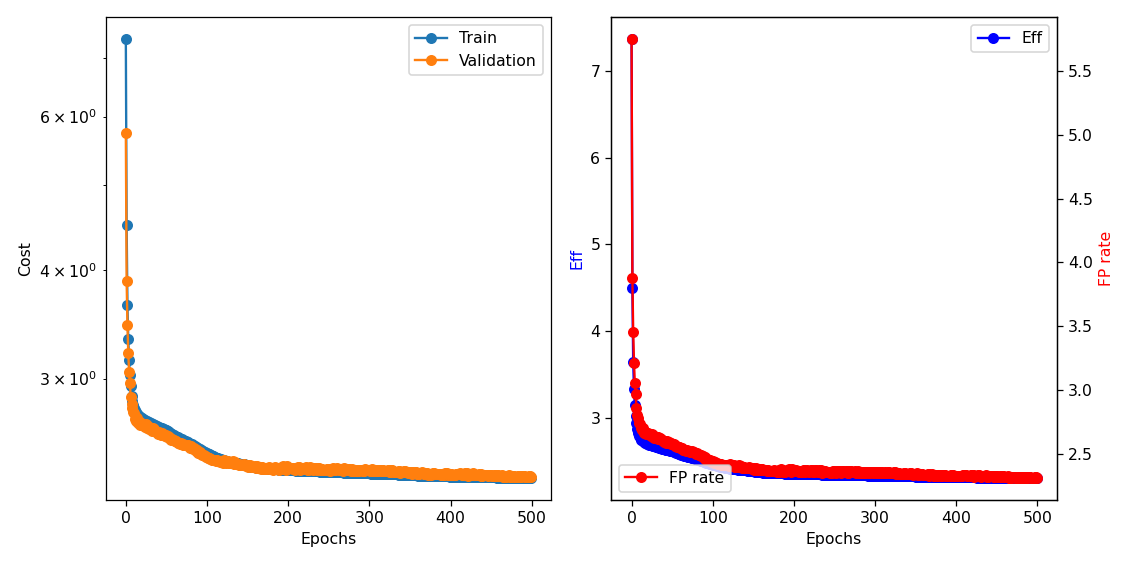

In [25]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [26]:
##quit()


## 